In [55]:
print("[+] Importing Modules...")
import numpy as np
import pandas as pd
import re, sys, os, csv, keras, pickle
import matplotlib.pyplot as plt
import itertools, pickle
from itertools import product
from numpy import savetxt
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Input, Flatten, Concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from keras.engine.topology import Layer, InputSpec
print("[+] Finished Importing Modules!")
print("[+] Using Keras version",keras.__version__)

[+] Importing Modules...
[+] Finished Importing Modules!
[+] Using Keras version 2.4.3


In [98]:
MAX_NB_WORDS = 40000         # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 30     # max length of text (words) including padding
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 200          # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "data_files/glove.twitter.27B."+str(200)+"d.txt"
print("[+] Loaded Parameters:\n", MAX_NB_WORDS,MAX_SEQUENCE_LENGTH+5, VALIDATION_SPLIT,EMBEDDING_DIM,"\n", GLOVE_DIR)

[+] Loaded Parameters:
 40000 35 0.2 200 
 data_files/glove.twitter.27B.200d.txt


In [64]:
texts, labels = [], []
print("[+] Reading from csv file...", end="")
with open('data_files/text_labels.csv') as csvfile: #CSV file containing label, image (and optionally, text)
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        texts.append(row[1])
        labels.append(row[0])
print("Done!")

[+] Reading from csv file...Done!


In [99]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
with open('data_files/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("[+] Saved word tokenizer to file: tokenizer.pickle")

[+] Saved word tokenizer to file: tokenizer.pickle


In [66]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [67]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('[i] Found %s unique tokens.' % len(word_index))
data_int = pad_sequences(sequences, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data = pad_sequences(data_int, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))

[i] Found 54393 unique tokens.


In [68]:
labels = to_categorical(np.asarray(labels))       # convert to one-hot encoding vectors
print('[+] Shape of data tensor:', data.shape)
print('[+] Shape of label tensor:', labels.shape)

[+] Shape of data tensor: (97170, 30)
[+] Shape of label tensor: (97170, 4)


In [69]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [70]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('[i] Number of entries in each category:')
print("[+] Training:\n",y_train.sum(axis=0))
print("[+] Validation:\n",y_val.sum(axis=0))

[i] Number of entries in each category:
[+] Training:
 [42768. 12767.  3915. 18286.]
[+] Validation:
 [10615.  3183.   922.  4714.]


In [71]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding="utf8")
print("[+] Loading GloVe from:",GLOVE_DIR,"...",end="")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n[+] Proceeding with Embedding Matrix...", end="")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print("[+] Completed!")

[+] Loading GloVe from: glove.twitter.27B.200d.txt ...Done.
[+] Proceeding with Embedding Matrix...[+] Completed!


In [72]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [73]:
def initial_boost(epoch):
    if epoch==0: return float(8.0)
    elif epoch==1: return float(4.0)
    elif epoch==2: return float(2.0)
    elif epoch==3: return float(1.5)
    else: return float(1.0)

In [74]:
def step_cyclic(epoch):
    try:
        l_r, decay = 1.0, 0.0001
        if epoch%33==0:multiplier = 10
        else:multiplier = 1
        rate = float(multiplier * l_r * 1/(1 + decay * epoch))
        #print("Epoch",epoch+1,"- learning_rate",rate)
        return rate
    except Exception as e:
        print("Error in lr_schedule:",str(e))
        return float(1.0)

In [75]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector

In [76]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

In [77]:
l_lstm1f = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)
l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])

In [78]:
l_conv_2 = Conv1D(filters=24,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.3)(l_conv_2)
l_conv_3 = Conv1D(filters=24,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=24,kernel_size=5,activation='relu',)(l_lstm1)
l_conv_5 = Dropout(0.3)(l_conv_5)
l_conv_6 = Conv1D(filters=24,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_6 = Dropout(0.3)(l_conv_6)

l_conv_8 = Conv1D(filters=24,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_8 = Dropout(0.3)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_8,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

In [79]:
l_conv_4f = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_frozen)
l_conv_4f = Dropout(0.3)(l_conv_4f)
l_conv_4t = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_train)
l_conv_4t = Dropout(0.3)(l_conv_4t)

l_conv_3f = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_frozen)
l_conv_3f = Dropout(0.3)(l_conv_3f)
l_conv_3t = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_train)
l_conv_3t = Dropout(0.3)(l_conv_3t)

l_conv_2f = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_frozen)
l_conv_2f = Dropout(0.3)(l_conv_2f)
l_conv_2t = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_train)
l_conv_2t = Dropout(0.3)(l_conv_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t]

l_merge_2 = Concatenate(axis=1)(conv_2)
l_c_lstm = Bidirectional(LSTM(12,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(l_merge_2)

In [80]:
l_merge = Concatenate(axis=1)([l_lstm_c, l_c_lstm])
l_pool = MaxPooling1D(4)(l_merge)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(26, activation='relu')(l_flat)
preds = Dense(4, activation='softmax')(l_dense)

In [81]:
model = Model(sequence_input, preds)
adam_opt = optimizers.Adam(lr=0.001)
lr_metric = get_lr_metric(adam_opt)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [82]:
tensorboard = callbacks.TensorBoard(log_dir='tb_logs', histogram_freq=0, batch_size=16, write_grads=True , write_graph=True)
model_checkpoints = callbacks.ModelCheckpoint("model_checkpoints/checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0)
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

In [83]:
model.summary()
#model.save('model_checkpoints/BalanceNet.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 200)      10878800    input_2[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 30, 200)      10878800    input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 30, 12)       9936        embedding_2[0][0]                
____________________________________________________________________________________________

In [84]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=1, batch_size=256,callbacks=[tensorboard, model_checkpoints])

#pandas.DataFrame(model_log.history).to_csv("history-balance.csv")

Training Progress:
304/304 [==============================] - 184s 604ms/step - loss: 0.0882 - accuracy: 0.7636 - val_loss: 0.0608 - val_accuracy: 0.8420


In [85]:
%config InlineBackend.figure_format = 'retina'
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

classes = ["happy", "sad", "hate","anger"]

In [86]:
#model_test = load_model('data_files/best_weights.h5')
Y_test = np.argmax(labels, axis=1)          # Convert one-hot to index
y_pred = model.predict(data)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

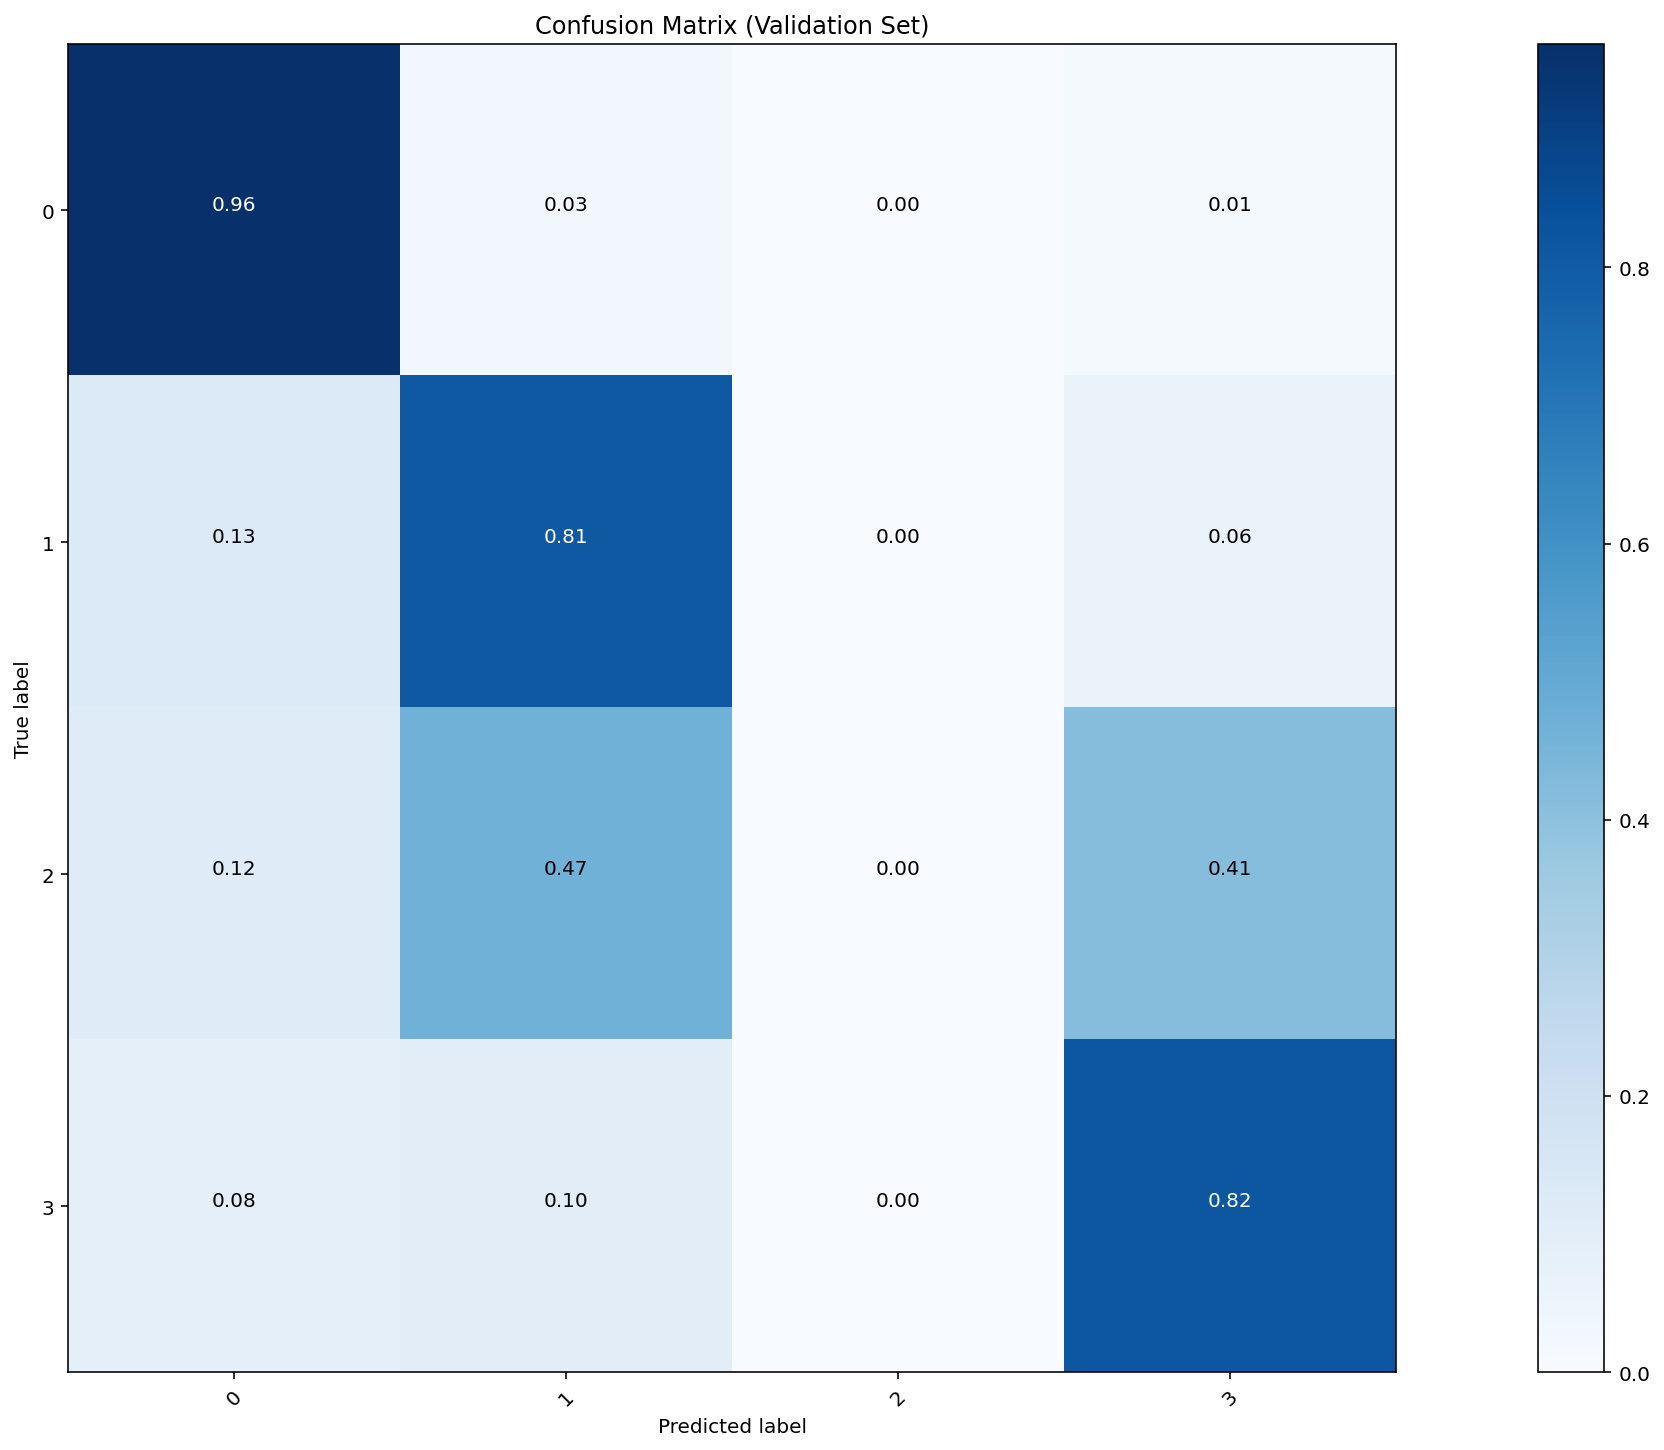

In [87]:
def plot_confusion_matrix(cm, labels, normalize=True, title='Confusion Matrix (Validation Set)', cmap=plt.cm.Blues):
"""
This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(4)
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=None)

# precision = true_pos / (true_pos + false_pos)
# recall = true_pos / (true_pos + false_neg)

In [88]:
print(y_pred)

[[2.11785380e-02 3.45874578e-01 1.67554304e-01 4.65392560e-01]
 [4.88384128e-01 4.28976953e-01 5.16777597e-02 3.09611671e-02]
 [3.99476290e-02 1.67172477e-01 1.17119685e-01 6.75760210e-01]
 ...
 [9.96248662e-01 3.62552330e-03 7.70947736e-05 4.86981880e-05]
 [9.57241654e-01 2.99006961e-02 5.14406897e-03 7.71363452e-03]
 [8.16842139e-01 1.60890505e-01 1.30352173e-02 9.23214294e-03]]


In [97]:
print('Length:', len(y_pred))

Length: 97170


In [93]:
model.save('model_checkpoints/TER.h5')

In [94]:
savetxt('data_files/text_prob.csv', y_pred, delimiter=',')

In [95]:
savetxt('data_files/text_pred.csv', y_pred_class, delimiter=',')